In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage import io, color, feature, exposure
from skimage.feature import hog
import cv2
from sklearn.decomposition import PCA
from keras.utils import to_categorical

In [3]:
data = pd.read_csv(r'icml_face_data.csv')

In [4]:
data.shape

(35887, 3)

In [5]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [6]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [7]:
data.rename(columns={' Usage':'Usage',' pixels':'pixels'},inplace=True)
data.columns

Index(['emotion', 'Usage', 'pixels'], dtype='object')

In [8]:
emo = data.emotion.value_counts()
emo
#اكتر الناس فرحانة الحمدلله

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [9]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Text(0.5, 1.0, 'Emotions')

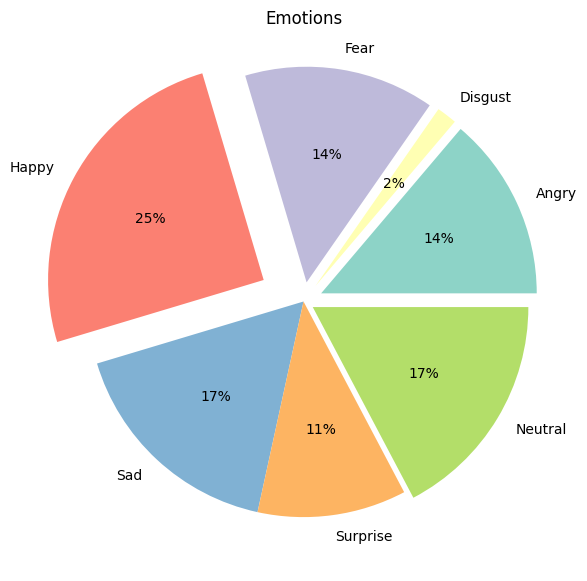

In [10]:
plt.figure(figsize=(7,7))
plt.pie(emo.sort_index(), labels=emotions.values(),colors=sns.color_palette('Set3'),autopct='%.0f%%',explode=[0.09, 0.09, 0.09, 0.21,0,0,0.05] )
plt.title("Emotions")

In [11]:

##as each image has it's pixels as only string consist of pixels so we need to make each image consist of a list of pixels 

In [12]:
def select_images(emotion_data):
    train = emotion_data[emotion_data['Usage']=='Training'].head(500)
    validation =  emotion_data[emotion_data['Usage']=='PrivateTest'].head(200) 
    test = emotion_data[emotion_data['Usage'] == 'PublicTest'].head(300)
    return pd.concat([train, validation,test])

rdata = data.groupby('emotion', group_keys=False).apply(lambda x: select_images(x))
rdata = rdata.reset_index(drop=True)
rdata.emotion.value_counts()

emotion
0    1000
2    1000
3    1000
4    1000
5    1000
6    1000
1     547
Name: count, dtype: int64

In [13]:
data = rdata
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,0,Training,30 24 21 23 25 25 49 67 84 103 120 125 130 139...
3,0,Training,123 125 124 142 209 226 234 236 231 232 235 22...
4,0,Training,8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...
...,...,...,...
6542,6,PublicTest,101 105 107 107 109 107 117 123 129 132 129 14...
6543,6,PublicTest,186 204 226 235 237 254 235 227 234 231 242 24...
6544,6,PublicTest,48 45 64 82 91 122 144 150 159 165 165 171 175...
6545,6,PublicTest,104 113 130 141 152 175 187 182 188 181 185 20...


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In [14]:
data.pixels = data.pixels.apply(lambda image : np.array(image.split(" ")).reshape(48,48,1).astype('uint8'))

In [15]:
data.pixels
#now each cell consist of 48*48 number , and only one copy of them because have a grayscale images

0       [[[70], [80], [82], [72], [58], [58], [60], [6...
1       [[[151], [150], [147], [155], [148], [133], [1...
2       [[[30], [24], [21], [23], [25], [25], [49], [6...
3       [[[123], [125], [124], [142], [209], [226], [2...
4       [[[8], [9], [14], [21], [26], [32], [37], [46]...
                              ...                        
6542    [[[101], [105], [107], [107], [109], [107], [1...
6543    [[[186], [204], [226], [235], [237], [254], [2...
6544    [[[48], [45], [64], [82], [91], [122], [144], ...
6545    [[[104], [113], [130], [141], [152], [175], [1...
6546    [[[28], [11], [0], [1], [1], [1], [1], [1], [0...
Name: pixels, Length: 6547, dtype: object

In [19]:
def resize_image(image,p1,p2):
    return cv2.resize(image, (p1, p2))

In [83]:
data['64_128px'] = data.pixels.apply(lambda image : resize_image(image,64,128))
data['128_256px'] = data.pixels.apply(lambda image : resize_image(image,128,256))

In [84]:
data['128_256px'][0].shape

(256, 128)

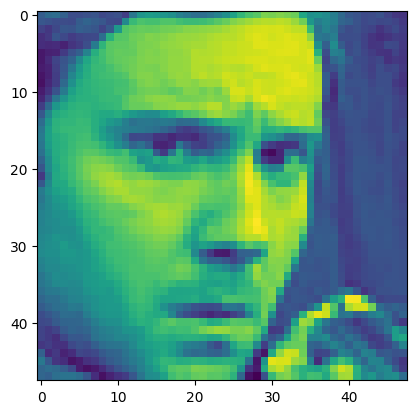

In [16]:
plt.imshow(data.pixels[0])

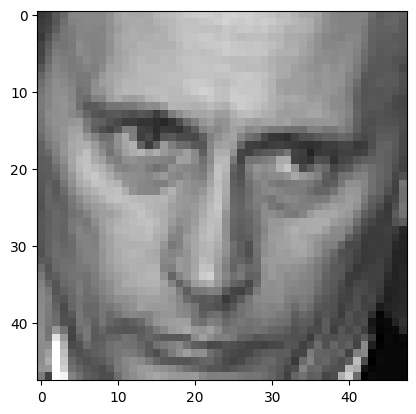

In [17]:
plt.imshow(data.pixels[9],cmap='gray')

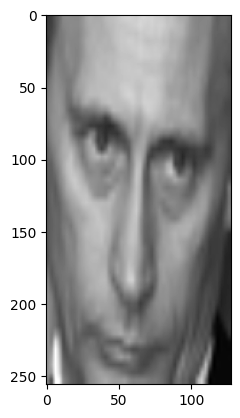

In [85]:
plt.imshow(data['128_256px'][9],cmap='gray')

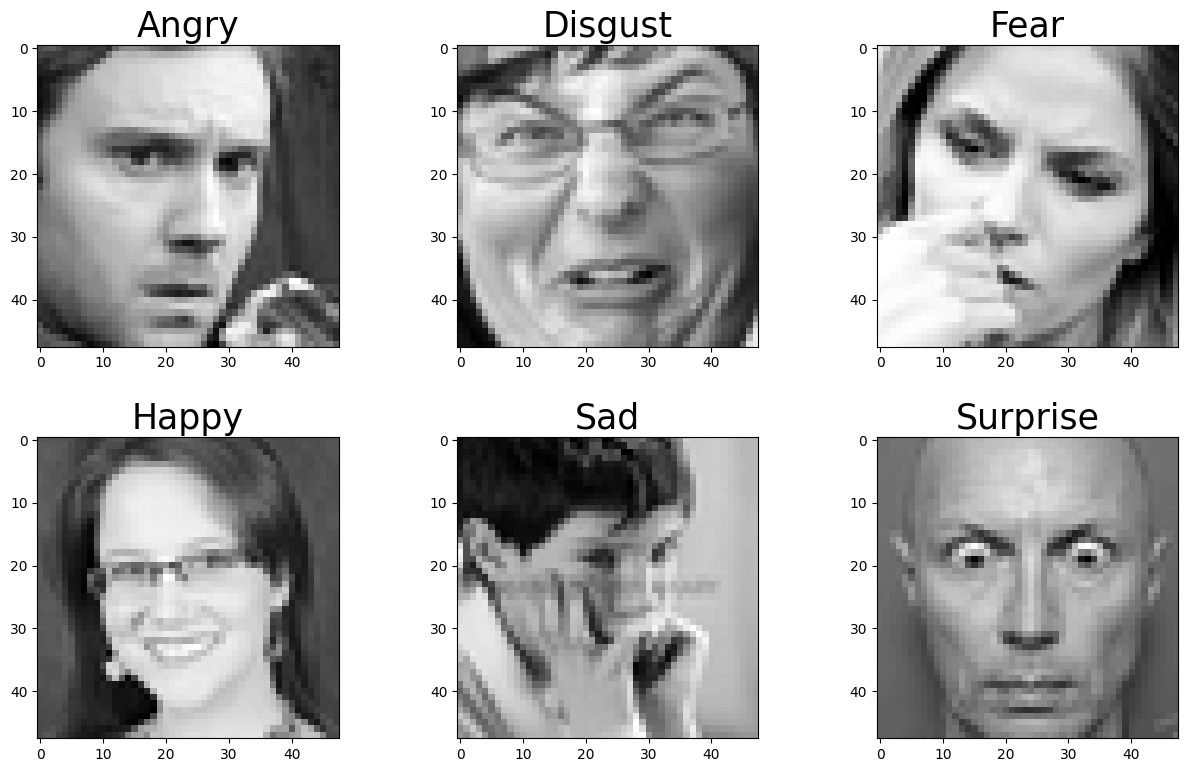

In [18]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,9))
index = []
for i,ax in enumerate(axes.flat):
    index.append(ax)

for i in([0,1,2,3,4,5]):
#    flag = False
    for j in range(len(data)):
        if (data.emotion[j]==i):
            #print(f"i= {i},j={j}")
            index[i].imshow(data.pixels[j],cmap='gray')
            index[i].set_title(emotions[i],{'fontsize':25})
#            flag =True
            break;
#    if (flag):
#        break

plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [21]:
def calculate_hog_features(image):
    image = image[:, :, 0]
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_features, hog_image_rescaled

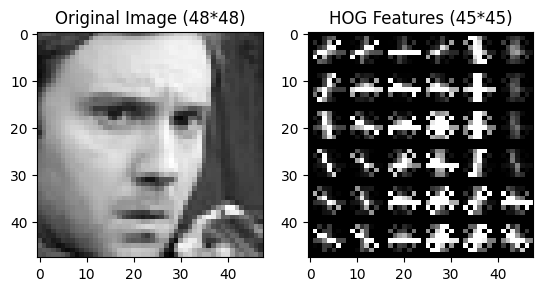

In [22]:
data['hog_features'], data['hog_images'] = zip(*data['pixels'].apply(lambda image : calculate_hog_features(image)))


plt.subplot(1, 2, 1)
plt.imshow(data.pixels[0], cmap='gray')
plt.title("Original Image (48*48)")

# Display the HOG features
plt.subplot(1, 2, 2)
plt.imshow(data['hog_images'][0], cmap='gray')
plt.title("HOG Features (45*45)")
plt.show()

In [23]:
def calculate_hog_features_for_resized(image):
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_features, hog_image_rescaled

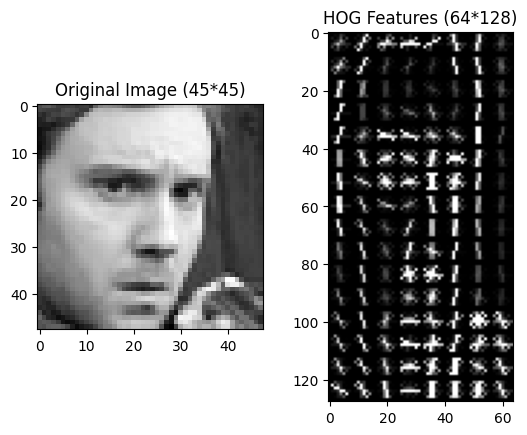

In [24]:
data['hog_features_64*128'], data['hog_image_64*128'] = zip(*data['64_128px'].apply(lambda x: calculate_hog_features_for_resized(x)))

plt.subplot(1, 2, 1)
plt.imshow(data['64_128px'][0], cmap='gray')
plt.title("Original Image (45*45)")

plt.subplot(1, 2, 2)
plt.imshow(data['hog_image_64*128'][0], cmap='gray')
plt.title("HOG Features (64*128)")
plt.show()

In [25]:
data.pixels

0       [[[70], [80], [82], [72], [58], [58], [60], [6...
1       [[[151], [150], [147], [155], [148], [133], [1...
2       [[[30], [24], [21], [23], [25], [25], [49], [6...
3       [[[123], [125], [124], [142], [209], [226], [2...
4       [[[8], [9], [14], [21], [26], [32], [37], [46]...
                              ...                        
6542    [[[101], [105], [107], [107], [109], [107], [1...
6543    [[[186], [204], [226], [235], [237], [254], [2...
6544    [[[48], [45], [64], [82], [91], [122], [144], ...
6545    [[[104], [113], [130], [141], [152], [175], [1...
6546    [[[28], [11], [0], [1], [1], [1], [1], [1], [0...
Name: pixels, Length: 6547, dtype: object

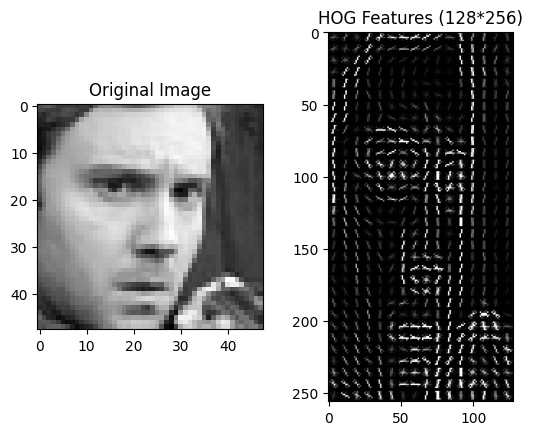

In [28]:
data['hog_features_128*256'], data['hog_image_128*256'] = zip(*data['128_256px'].apply(lambda x: calculate_hog_features_for_resized(x)))
plt.subplot(1, 2, 1)
plt.imshow(data['128_256px'][0], cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(data['hog_image_128*256'][0], cmap='gray')
plt.title("HOG Features (128*256)")
plt.show()

In [29]:
data.columns

Index(['emotion', 'Usage', 'pixels', '64_128px', '128_256px', 'hog_features',
       'hog_images', 'hog_features_64*128', 'hog_image_64*128',
       'hog_features_128*256', 'hog_image_128*256'],
      dtype='object')

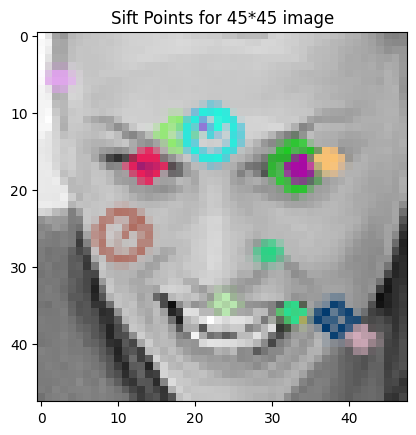

In [30]:
sift = cv2.SIFT_create()
#sift.detect?
keypoints = sift.detect(data.pixels[255],None)
kp, descriptor = sift.compute(data.pixels[255],keypoints)
img = cv2.drawKeypoints(data.pixels[255],kp,data.pixels[255],flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title('Sift Points for 45*45 image')
plt.imshow(img)
plt.show()

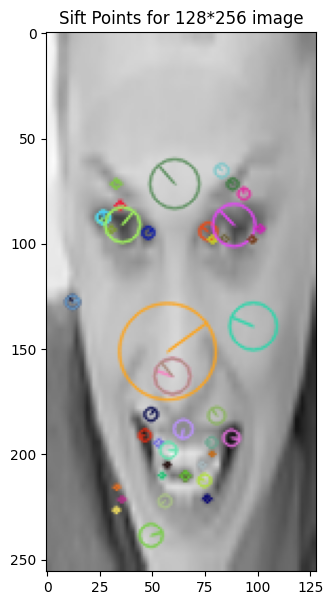

In [64]:
imgg = data['128_256px'][255]
key_points, description = sift.detectAndCompute(imgg, None)
img_building_keypoints = cv2.drawKeypoints(imgg, key_points, imgg, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.figure(figsize=(7,7))
plt.title('Sift Points for 128*256 image')
plt.imshow(img_building_keypoints)
plt.show()

In [32]:
def sift_algorithm(image):
    key_points, description = sift.detectAndCompute(image, None)
    return key_points,description 

data['sift_kp_128'] , data['sift_desc_128'] = zip(*data['128_256px'].apply(lambda x: sift_algorithm(x)))

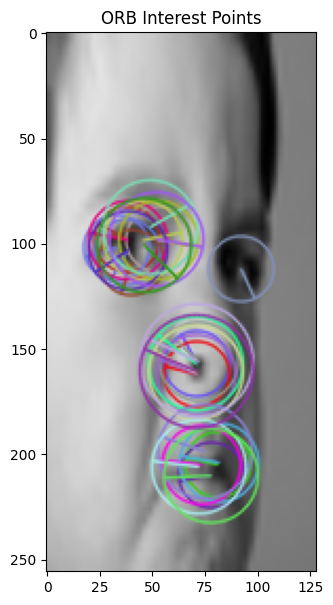

In [34]:
orb = cv2.ORB_create() 
imgg = resize_image(data.pixels[76],128,256)
#imgg = data.pixels[255]
key_points, description = orb.detectAndCompute(imgg, None)
img_building_keypoints = cv2.drawKeypoints(imgg, key_points, imgg, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(7,7))
plt.title('ORB Interest Points')
plt.imshow(img_building_keypoints)
plt.show()

In [35]:
def apply_orb(image):
    key_points, description = orb.detectAndCompute(image, None)
    return key_points,description 

data['orb_kp_128'] , data['orb_desc_128'] = zip(*data['128_256px'].apply(lambda x: apply_orb(x)))

In [94]:
image_data = np.stack(data['128_256px'].values) 
image_data = image_data.reshape(image_data.shape[0], -1)
#now each column represnts a pixel, and each row represents an image 
image_data = image_data / 255.0 #rescaling
image_data[0].shape

(32768,)

Text(0, 0.5, 'Cumulative Explained Variance')

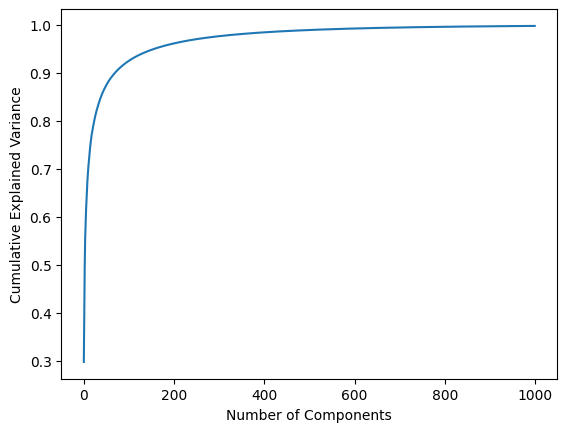

In [107]:
pca = PCA(n_components=1000)
pca.fit(image_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [109]:
pca = PCA(n_components=150)
pca_images = pca.fit_transform(image_data)

Text(0.5, 1.0, 'Average Face')

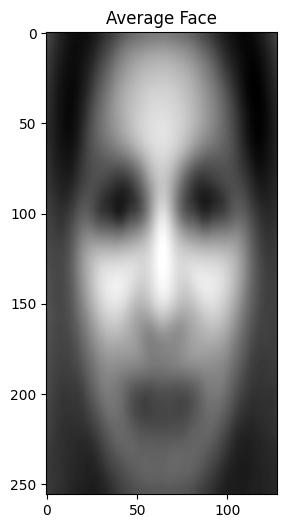

In [110]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(pca.mean_.reshape(256,128),cmap='gray')
ax.set_title('Average Face')

 the average face represents the typical facial appearance derived from a collection of face images, and it serves as a reference point for understanding the variations and patterns in the dataset.

By visualizing the average face, you can get an idea of the common features and characteristics shared by the faces in the dataset. It provides a baseline or reference for comparison with individual faces in terms of their variations from the average.

Text(0.5, 1.0, 'Reconstructed Image')

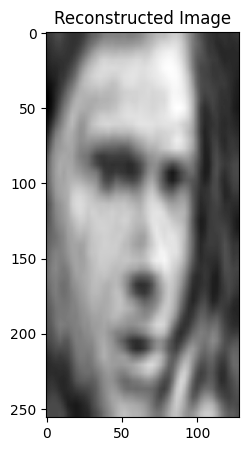

In [112]:
image_pca_components = pca_images[0]
reconstructed_image = pca.inverse_transform(image_pca_components)
reconstructed_image = reconstructed_image.reshape(256, 128)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(reconstructed_image, cmap='gray')
ax.set_title('Reconstructed Image')

In [113]:
pca_df = pd.DataFrame(pca_images,columns=["pca"+str(i) for i in range(1,151)])
pca_df['emotion'] = data['emotion']
pca_df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca142,pca143,pca144,pca145,pca146,pca147,pca148,pca149,pca150,emotion
0,11.235637,-8.486651,-11.693832,-5.343342,-7.340418,2.265680,-1.005451,-2.131636,1.679766,2.463230,...,0.624458,-0.055463,-1.173451,-1.679046,-0.581082,-1.352636,-1.015645,-0.221007,-0.734730,0
1,0.016157,9.005632,7.252180,-6.422809,-9.933720,1.785329,1.241950,-7.514327,-0.725154,2.174904,...,-1.554738,-0.469569,-0.306499,-2.375197,0.657820,0.158251,-1.139269,0.926656,-0.746541,0
2,14.583067,-11.950548,10.942752,-3.719683,-10.705987,2.746482,-2.025422,-0.496656,-1.446199,3.166182,...,-1.349691,0.000031,-0.428563,-0.427727,1.476460,0.649225,1.139446,0.135694,0.095400,0
3,-16.666583,4.454555,2.791181,-18.321381,-5.814531,-4.773943,-10.865793,-4.424377,4.293514,-4.344110,...,0.023079,-0.658881,-0.755975,0.711924,-0.009551,0.882931,0.828658,-0.784287,-0.322873,0
4,25.924420,3.401112,14.389050,-2.163447,-2.434237,5.080890,-4.886675,8.489889,-3.396610,-3.603197,...,0.913139,0.315720,0.963652,-0.215185,-1.230651,-0.432229,-0.188582,-0.764738,-0.569499,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6542,26.203607,15.674333,-11.053935,-7.247034,-1.842244,2.622918,-1.655157,-2.636561,-0.730997,-8.241750,...,0.681452,-0.129186,-0.087845,-0.948441,0.089960,-0.731971,0.597575,0.183575,1.271413,6
6543,-15.327951,10.180073,-15.565323,-8.847460,-11.159571,-8.342455,-13.707273,-2.619082,-9.809607,19.550742,...,-0.765287,-0.081826,-0.524876,-0.906494,0.130501,-0.801700,0.570146,-2.319923,0.729796,6
6544,-49.949176,-3.664536,11.269642,5.948929,-0.761210,10.412459,-4.421262,1.859834,0.818949,1.562635,...,-0.941657,-0.248913,0.031430,-1.225413,0.467246,0.020432,0.805683,0.324112,-0.192103,6
6545,-20.170591,-11.667664,-10.031326,-8.266637,3.352983,-1.324723,0.474624,1.115656,-8.114145,-0.451912,...,0.027705,-0.773940,-0.051240,1.087373,0.161316,-0.634719,0.135823,-0.942903,0.562983,6


In [ ]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48,1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = data.loc[row, 'pixels']
        image_array[i] = image
        
    return image_array, image_label

#split the training , validation,testing data
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [ ]:
#scaling the pixels values 
train_images = train_image_array.astype('float32')/255
val_images = val_image_array.astype('float32')/255
test_images = test_image_array.astype('float32')/255


train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
print(f"Number of training rows : {train_images.shape[0]}")
print(f"Number of validation rows : {val_images.shape[0]}")
print(f"Number of testing rows : {test_images.shape[0]}")

Number of training rows : 3436
Number of validation rows : 1255
Number of testing rows : 1856
